# This notebook investigates the overall superiority of methods over another in a pairwise manner by using Bayseian statistics.

In [1]:
import pymc as pm
import numpy as np
import arviz as az
import pandas as pd
from itertools import product
import matplotlib.pyplot as plt

import logging
logger = logging.getLogger('pymc3')
logger.setLevel(logging.ERROR)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

RESULTS_DIR = '../results'

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Prepare data

In [2]:
# Mapping to increase readability
method_mapping = {
    'naive' : 'Ablation 1',
    'positive' : 'Ablation 2',
    'aum' : 'AUM',
    'entropy' : 'Entropy',
    'normalized_margins': 'Normalized Margins',
    'cross_val': 'Self-Confidence',
    'cleanlab': 'CleanLab',
}

# Load the data
df = pd.read_csv(RESULTS_DIR + "/label_error_trials.csv")
df["method"] = df["method"].apply(lambda x: method_mapping[x])

# Drop Entropy as it is not used in the analysis
df = df[df["method"] != "Entropy"]

# Get the unique values for each column
ds_names = list(df["ds_name"].unique())
noise_types = list(df["noise_type"].unique())
noise_levels = list(df["noise_level"].unique())
methods = list(np.sort(df["method"].unique()))

# Pivot the data in order to have a column for each method
index_cols = ["ds_name", "noise_type", "noise_level", "random_state"]
df = df.pivot_table(
    index=index_cols, columns="method", values="auroc"
).reset_index()

# Get the indices for a given condition
ds_name_idx = df["ds_name"].apply(lambda x: ds_names.index(x)).values
noise_type_idx = df["noise_type"].apply(lambda x: noise_types.index(x)).values
noise_level_idx = df["noise_level"].apply(lambda x: noise_levels.index(x)).values

n_ds = len(ds_names)
n_noise_types = len(noise_types)
n_noise_levels = len(noise_levels)
n_methods = len(methods)
n_samples = len(df)

scores = df.drop(columns=index_cols).values
print(scores.shape)

(540, 6)


## Compute target values
The idea is to compare the performance of two methods on a dataset and determine if one method is superior to the other.
Therefore, we compute for each pair of methods and the same random state the sign of the difference in performance.

In [3]:
# Compute pairwise superiority
Y = np.zeros((n_methods, n_methods, n_samples))
for i in range(n_methods):
    for j in range(n_methods):
        Y[i, j] = scores[:, i] > scores[:, j]
print(Y.shape)

(6, 6, 540)


## Model the target values via a Bernoulli distribution and a hierarchical model
We assume that the data set, the noise type and the noise level have an influence on the performance of the methods.
The residual effect is then assumed to be the overall method effect.

In [4]:
np.random.seed(42)

def sample_posterior(Y, verbose=True, prior_predictive_check=True):
    """Sample the posterior distribution of the model"""
    # Bayesian Hierarchical Binomial Model
    with pm.Model() as model:
        ## Priors
        # Main method effect
        mu = pm.Normal("mu", mu=0, sigma=1)

        # Effects for datasets, noise_types and noise levels 
        alpha = pm.Normal("alpha", mu=0, sigma=0.5, shape=n_ds)
        beta = pm.Normal("beta", mu=0, sigma=0.5, shape=n_noise_types)
        gamma = pm.Normal("gamma", mu=0, sigma=0.5, shape=n_noise_levels)
        
        # Logit-transformed probability for each dataset-noise level pair
        logit_theta = mu + alpha[ds_name_idx] + beta[noise_type_idx] + gamma[noise_level_idx]
        theta = pm.Deterministic("theta", pm.math.sigmoid(logit_theta))
        
        # Likelihood: observed win/loss outcomes
        Y_obs = pm.Bernoulli("Y_obs", p=theta, observed=Y)
        prior_pred_samples = pm.sample_prior_predictive(samples=2000)

        if prior_predictive_check:
            fig, ax = plt.subplots(1, 2, figsize=(14, 3))
            ax[0].hist(
                prior_pred_samples["prior"]["theta"].values.flatten(), 
                bins=30, density=True, alpha=0.7, label="mu"
            )
            ax[0].set_title("Prior Predictive Distribution for Theta")
            ax[0].set_xlabel("Theta (Win Probability)")
            ax[0].set_ylabel("Density")
            ax[0].legend()

            # Plot the simulated outcomes
            prior_predictive = prior_pred_samples["prior_predictive"]
            ax[1].hist(
                np.mean(prior_predictive["Y_obs"].values, axis=-1).flatten(), 
                bins=30, density=True, alpha=0.7, label="mu"
            )
            ax[1].set_title("Prior Predictive Distribution for Simulated Outcomes")
            ax[1].set_xlabel("Mean Win Probability (Simulated)")
            ax[1].set_ylabel("Density")
            ax[1].legend()
            plt.show()

        # Inference
        samples = pm.sample(
            2000, tune=1000, chains=4, target_accept=0.95, n_init=1000, 
            keep_warning_stat=verbose, progressbar=verbose
        )
        
        return samples
    
def get_estimate(trace, H0=0.5):
    """Get the estimate for the posterior mean, HDI and p-value"""
    summary = az.summary(
        trace, var_names=["mu", "alpha", "beta", "gamma"], hdi_prob=0.95
    )

    lb = sigmoid(summary["hdi_2.5%"].values[0])
    ub = sigmoid(summary["hdi_97.5%"].values[0])

    mus = trace["posterior"]["mu"].values
    thetas = sigmoid(mus)
    theta_mean = sigmoid(mus.mean())
    p_value = 1 - np.mean(thetas > H0)
    
    return theta_mean, lb, ub, p_value

### Example comparison with prior predictive check

Sampling: [Y_obs, alpha, beta, gamma, mu]


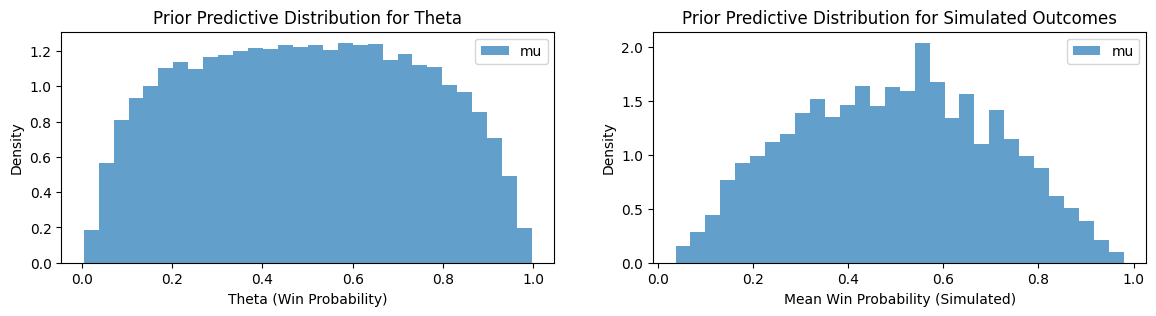

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, alpha, beta, gamma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 55 seconds.


theta: 0.95, lb: 0.88, ub: 0.98, p_value: 0.0
           mean     sd  hdi_2.5%  hdi_97.5%
mu        2.893  0.478     1.984      3.840
alpha[0]  0.368  0.443    -0.490      1.252
alpha[1]  0.363  0.438    -0.453      1.267
alpha[2]  0.359  0.441    -0.475      1.242
alpha[3] -2.187  0.341    -2.816     -1.479
alpha[4]  0.362  0.444    -0.497      1.232
alpha[5]  0.372  0.441    -0.522      1.212
alpha[6]  0.363  0.435    -0.503      1.204
alpha[7]  0.363  0.439    -0.514      1.194
alpha[8]  0.363  0.437    -0.453      1.262
beta[0]   0.365  0.381    -0.321      1.180
beta[1]   0.364  0.377    -0.382      1.082
gamma[0]  0.003  0.366    -0.732      0.697
gamma[1]  0.366  0.375    -0.350      1.112
gamma[2]  0.364  0.381    -0.380      1.105


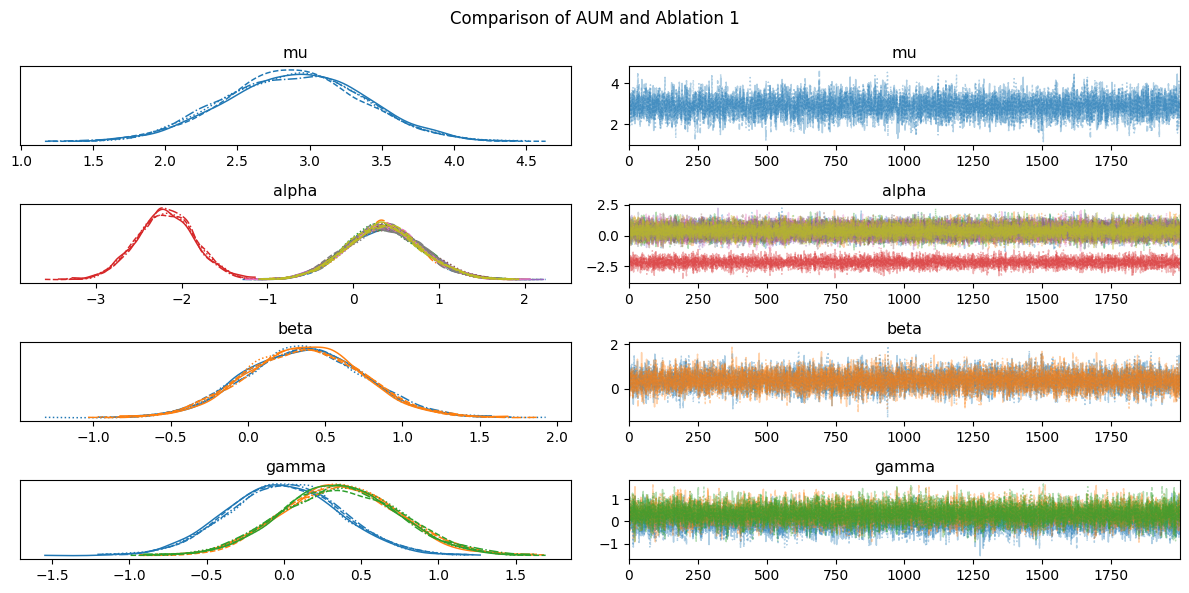

In [5]:
# Example: compare AUM and Ablation 1
compare_methods = ["AUM", "Ablation 1"]
idxs = [methods.index(m) for m in compare_methods]
trace = sample_posterior(Y[idxs[0], idxs[1]], verbose=True)

theta, lb, ub, p_value = get_estimate(trace)
print(f"theta: {theta:.2f}, lb: {lb:.2f}, ub: {ub:.2f}, p_value: {p_value}")

summary = az.summary(
    trace, var_names=["mu","alpha", "beta", "gamma"], hdi_prob=0.95
)
print(summary.iloc[:, :4])

az.plot_trace(
    trace, var_names=["mu", "alpha", "beta", "gamma"], figsize=(12, 6)
)
title = f"Comparison of {compare_methods[0]} and {compare_methods[1]}"
plt.suptitle(title)
plt.tight_layout()
plt.show()

### Compare all pairs of methods

Sampling: [Y_obs, alpha, beta, gamma, mu]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, alpha, beta, gamma]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 44 seconds.



AUM -> Ablation 1: theta_mu: 0.95, lb: 0.88, ub: 0.98, p_value: 0.0000


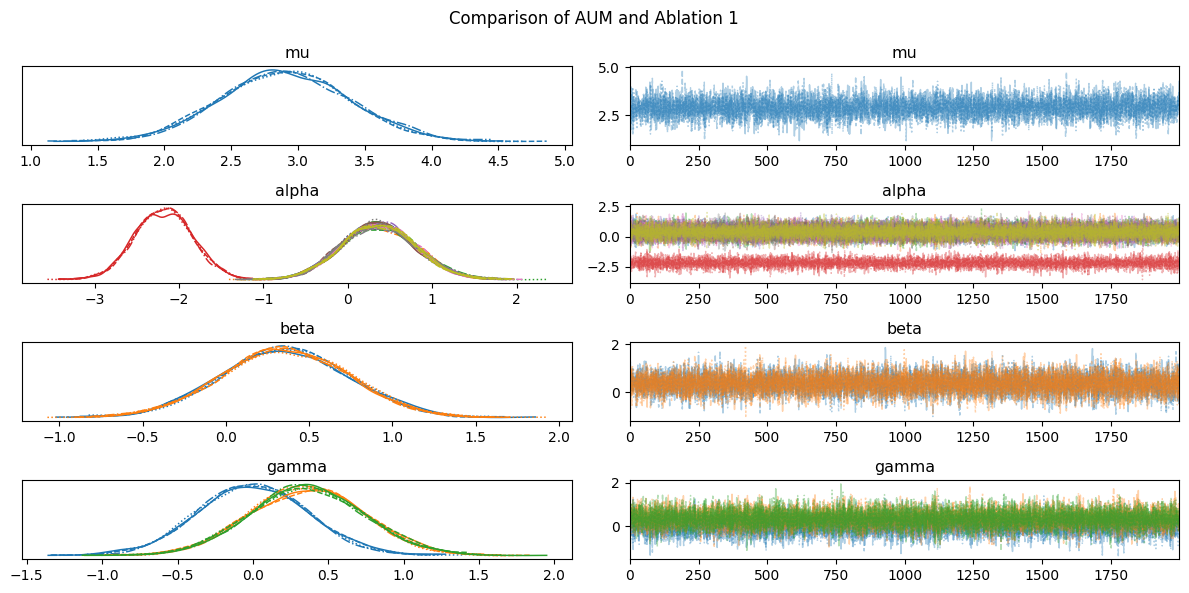

Sampling: [Y_obs, alpha, beta, gamma, mu]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, alpha, beta, gamma]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 50 seconds.



AUM -> Ablation 2: theta_mu: 0.58, lb: 0.36, ub: 0.77, p_value: 0.2312


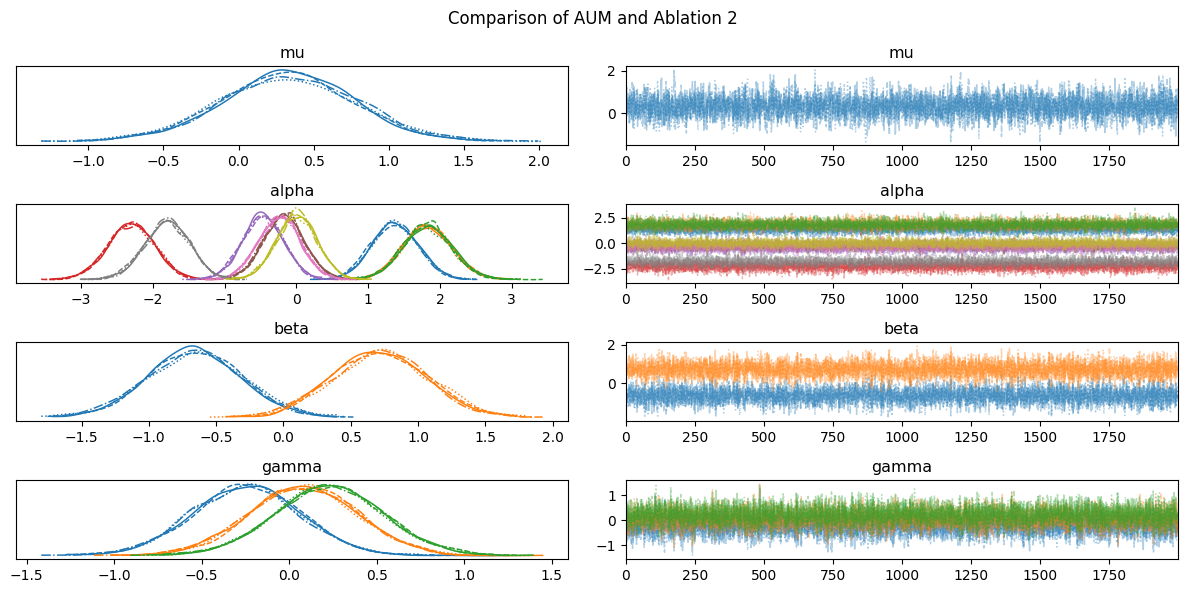

Sampling: [Y_obs, alpha, beta, gamma, mu]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, alpha, beta, gamma]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 43 seconds.



AUM -> CleanLab: theta_mu: 0.97, lb: 0.93, ub: 0.99, p_value: 0.0000


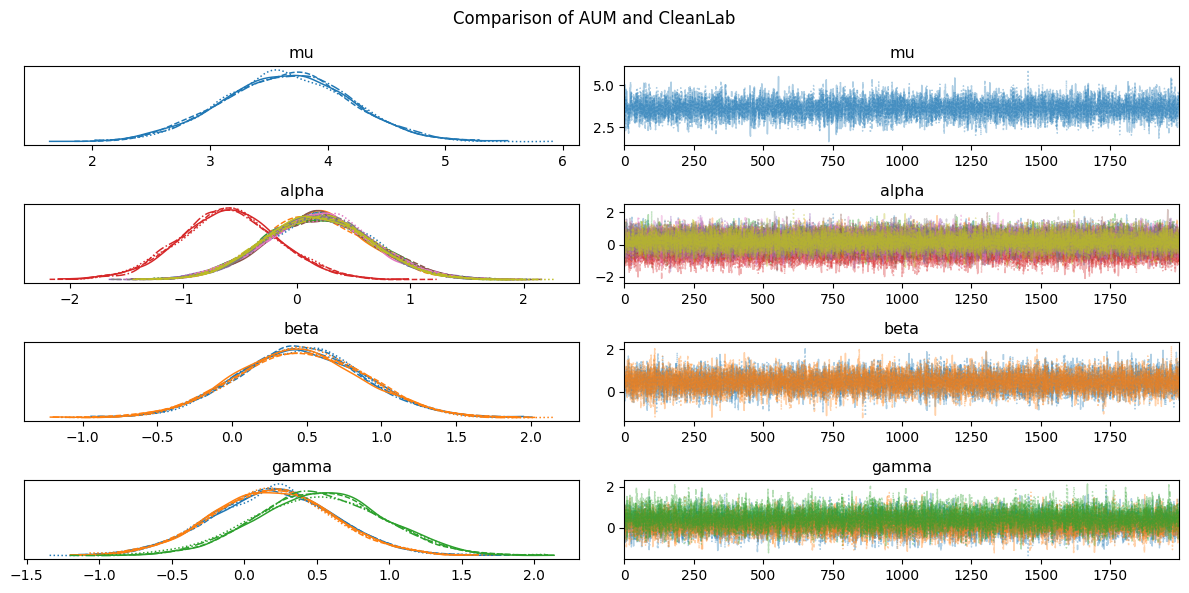

Sampling: [Y_obs, alpha, beta, gamma, mu]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, alpha, beta, gamma]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 58 seconds.



AUM -> Normalized Margins: theta_mu: 0.49, lb: 0.29, ub: 0.71, p_value: 0.5282


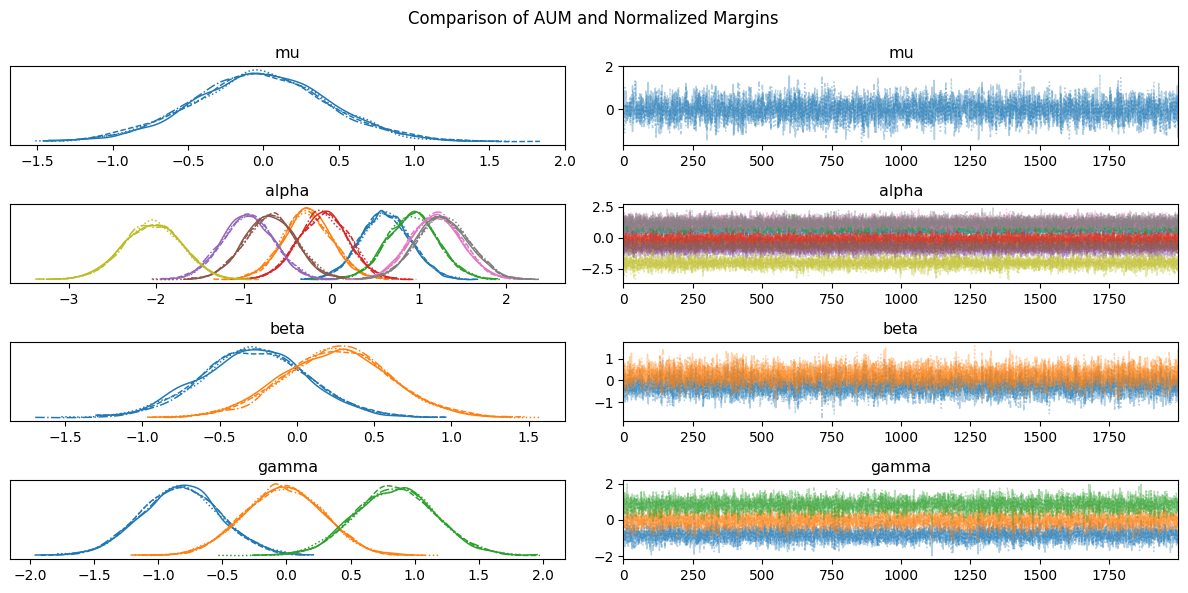

Sampling: [Y_obs, alpha, beta, gamma, mu]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, alpha, beta, gamma]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 51 seconds.



AUM -> Self-Confidence: theta_mu: 0.48, lb: 0.28, ub: 0.69, p_value: 0.5725


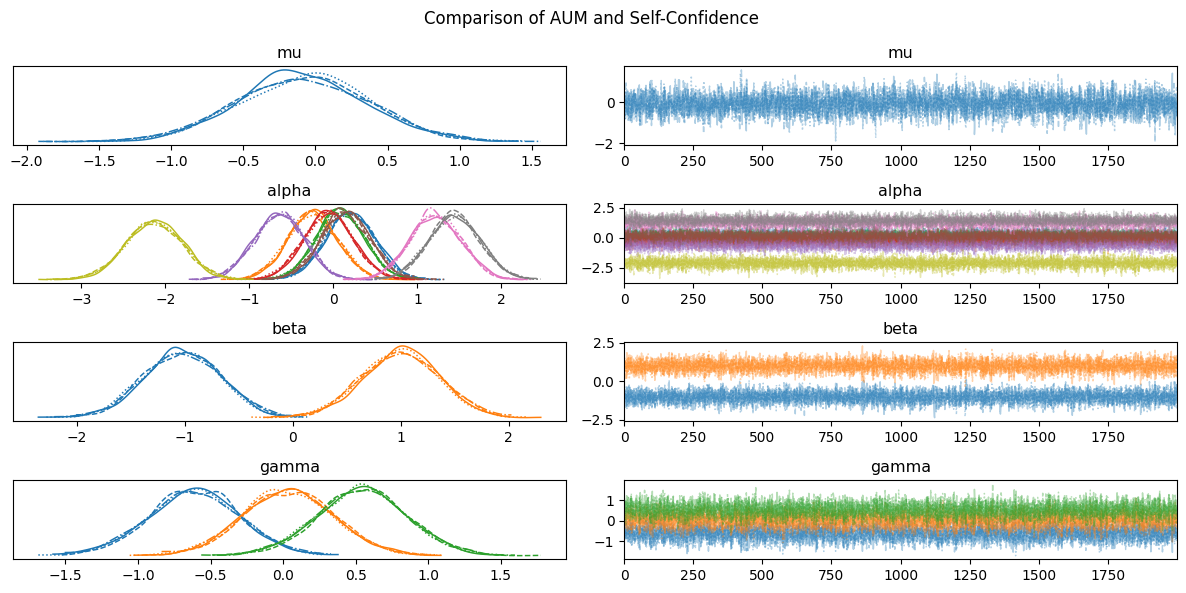

Sampling: [Y_obs, alpha, beta, gamma, mu]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, alpha, beta, gamma]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 36 seconds.



Ablation 1 -> Ablation 2: theta_mu: 0.08, lb: 0.03, ub: 0.18, p_value: 1.0000


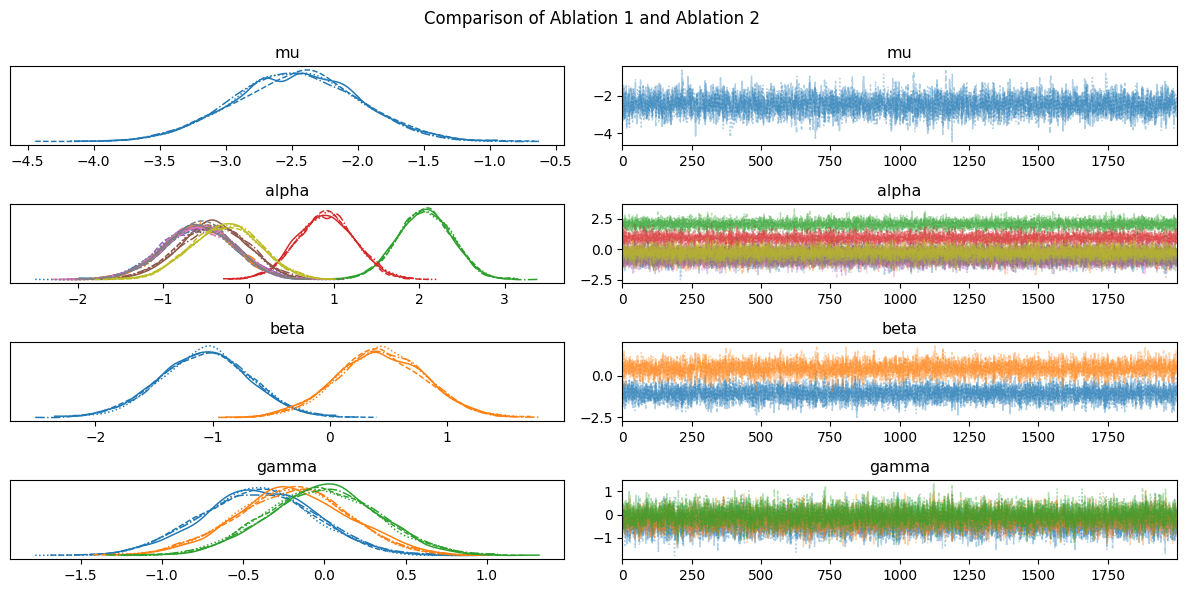

Sampling: [Y_obs, alpha, beta, gamma, mu]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, alpha, beta, gamma]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 46 seconds.



Ablation 1 -> CleanLab: theta_mu: 0.86, lb: 0.72, ub: 0.93, p_value: 0.0001


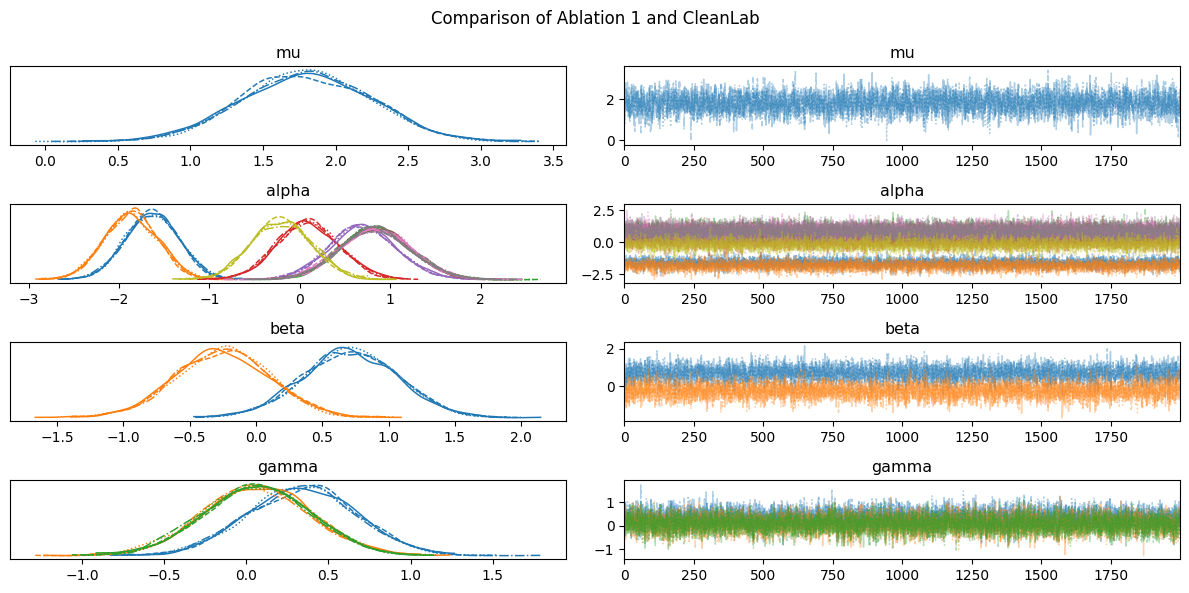

Sampling: [Y_obs, alpha, beta, gamma, mu]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, alpha, beta, gamma]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 51 seconds.



Ablation 1 -> Normalized Margins: theta_mu: 0.06, lb: 0.02, ub: 0.13, p_value: 1.0000


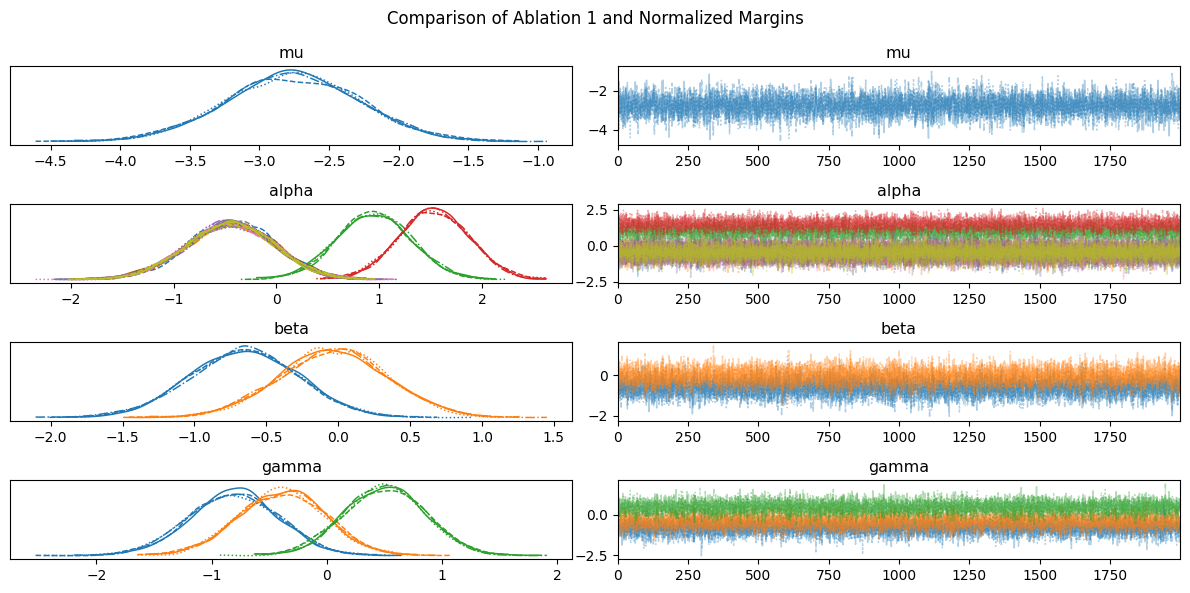

Sampling: [Y_obs, alpha, beta, gamma, mu]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, alpha, beta, gamma]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 42 seconds.



Ablation 1 -> Self-Confidence: theta_mu: 0.09, lb: 0.04, ub: 0.19, p_value: 1.0000


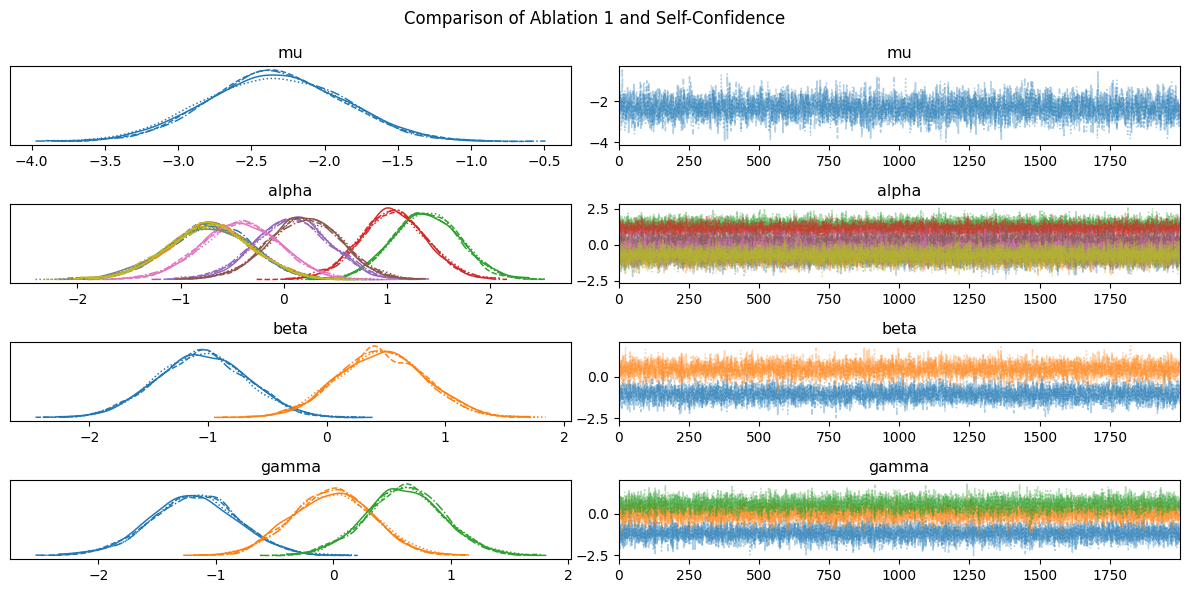

Sampling: [Y_obs, alpha, beta, gamma, mu]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, alpha, beta, gamma]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 41 seconds.



Ablation 2 -> CleanLab: theta_mu: 0.97, lb: 0.93, ub: 0.99, p_value: 0.0000


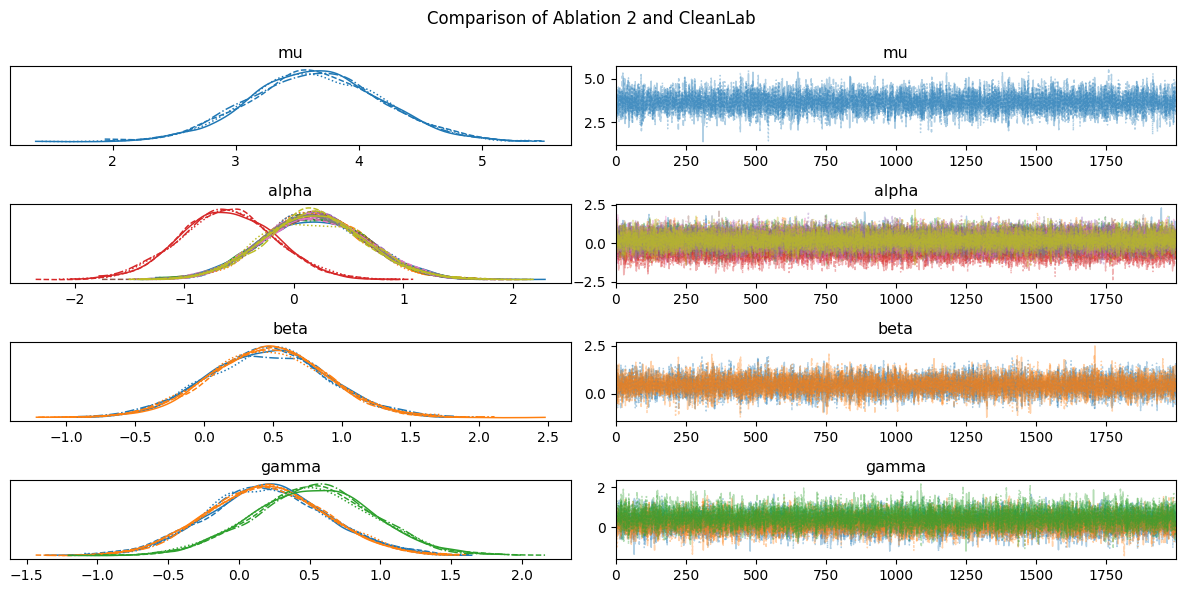

Sampling: [Y_obs, alpha, beta, gamma, mu]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, alpha, beta, gamma]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 48 seconds.



Ablation 2 -> Normalized Margins: theta_mu: 0.31, lb: 0.16, ub: 0.52, p_value: 0.9621


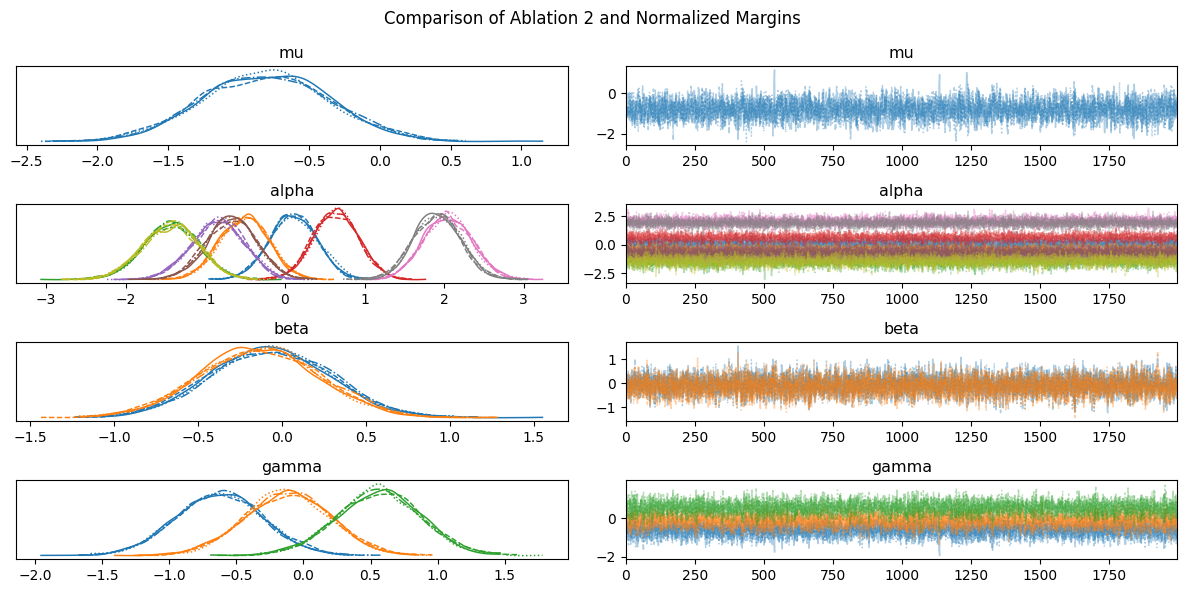

Sampling: [Y_obs, alpha, beta, gamma, mu]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, alpha, beta, gamma]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 53 seconds.



Ablation 2 -> Self-Confidence: theta_mu: 0.41, lb: 0.22, ub: 0.62, p_value: 0.7865


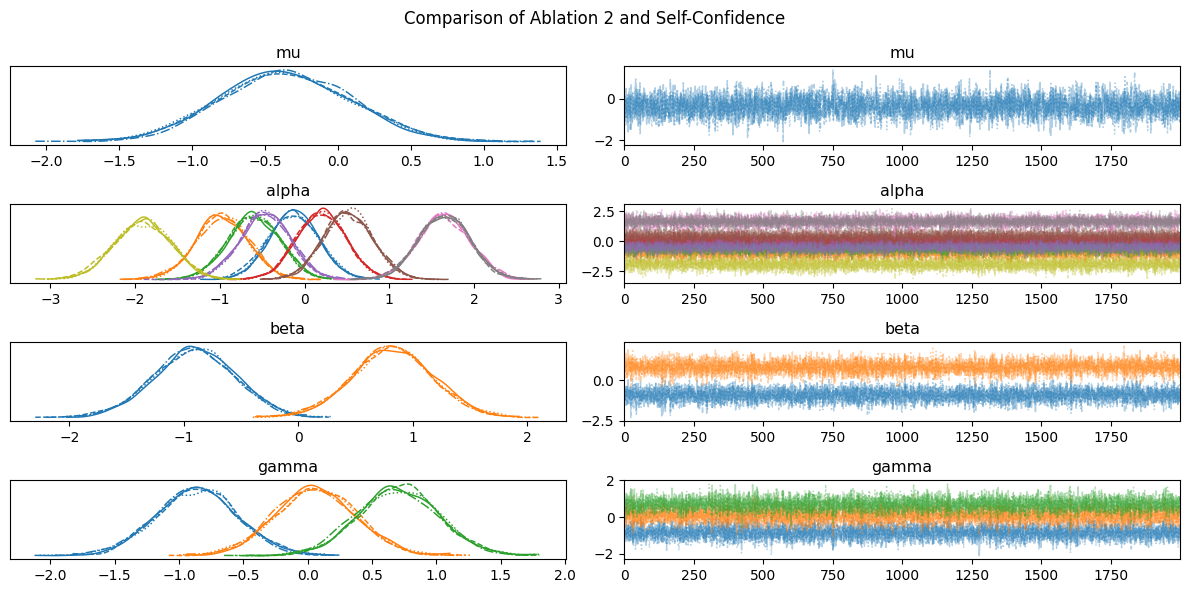

Sampling: [Y_obs, alpha, beta, gamma, mu]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, alpha, beta, gamma]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 40 seconds.



CleanLab -> Normalized Margins: theta_mu: 0.03, lb: 0.01, ub: 0.07, p_value: 1.0000


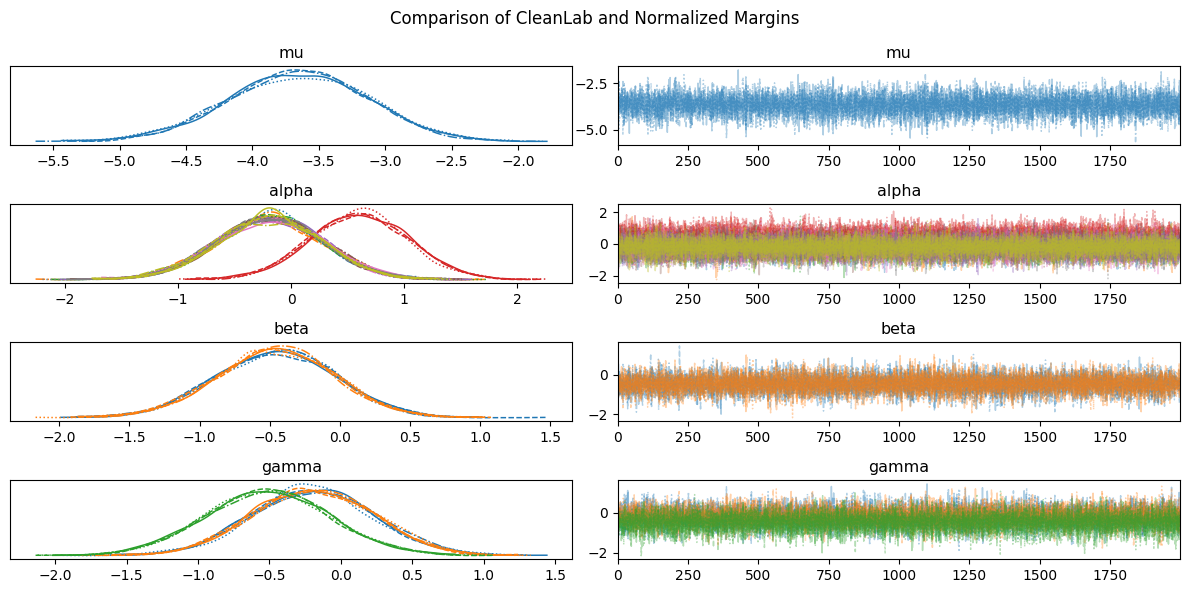

Sampling: [Y_obs, alpha, beta, gamma, mu]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, alpha, beta, gamma]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 33 seconds.



CleanLab -> Self-Confidence: theta_mu: 0.03, lb: 0.01, ub: 0.07, p_value: 1.0000


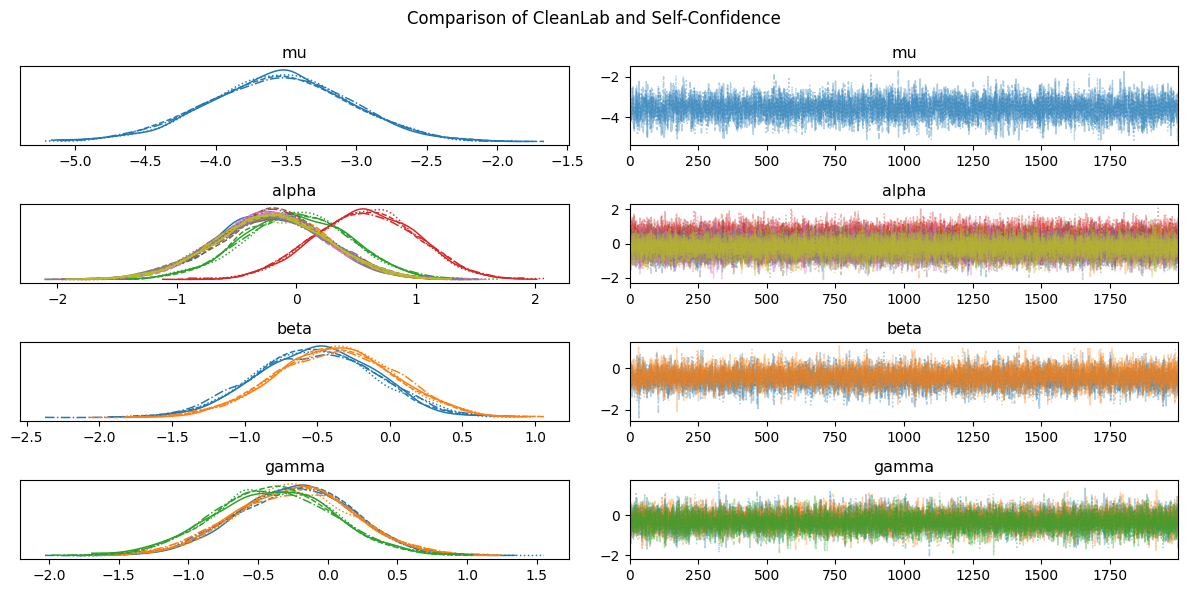

Sampling: [Y_obs, alpha, beta, gamma, mu]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, alpha, beta, gamma]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 47 seconds.



Normalized Margins -> Self-Confidence: theta_mu: 0.42, lb: 0.24, ub: 0.64, p_value: 0.7499


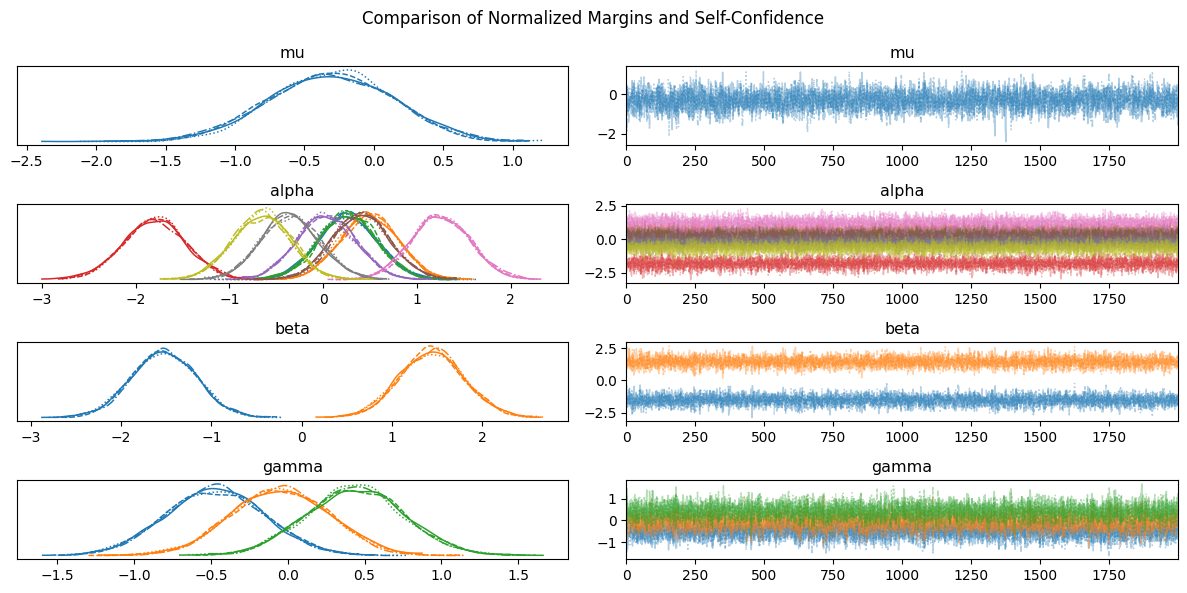

In [6]:
# Get all pairs of methods without duplicates
compare_pairs = list(product(methods, methods))
compare_pairs = [(a, b) for a, b in compare_pairs if a != b]
compare_pairs = list(set([tuple(sorted(pair)) for pair in compare_pairs]))
compare_pairs = sorted(compare_pairs, key=lambda x: (x[0], x[1]))

dfs = []
# Iterate over all pairs of methods
for i, pair in enumerate(compare_pairs):
    # Sample the posterior
    trace = sample_posterior(
        Y[methods.index(pair[0]), methods.index(pair[1])], 
        verbose=False, prior_predictive_check=False
    )
    # Get the estimate and summary
    theta, lb, ub, p_value = get_estimate(trace)
    summary = az.summary(
        trace, var_names=["mu","alpha", "beta", "gamma"], hdi_prob=0.95
    )
    
    # Print the results
    print(
        f"\n{pair[0]} -> {pair[1]}: theta_mu: {theta:.2f},"
        f" lb: {lb:.2f}, ub: {ub:.2f}, p_value: {p_value:.4f}"
    )

    # Create estimates dataframe
    df = pd.DataFrame(
        np.array([[theta, lb, ub, p_value]]), 
        index=[f"{pair[0]} -> {pair[1]}"], 
        columns=["theta_mu", "lb", "ub", "p_value"]
    )
    # Create summary dataframe
    other_df = pd.DataFrame(
        summary.iloc[:, 0].values.reshape(1, -1), 
        index=[f"{pair[0]} -> {pair[1]}"],
        columns=summary.index
    )
    dfs.append(pd.concat([df, other_df], axis=1))

    # Plot the trace
    az.plot_trace(
        trace, var_names=["mu", "alpha", "beta", "gamma"], figsize=(12, 6)
    )
    title = f"Comparison of {pair[0]} and {pair[1]}"
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

df = pd.concat(dfs)
df.round(5).to_csv(RESULTS_DIR + "/bayes_posterior.csv")

### Investigate results

In [7]:
# make print outputs wider
pd.set_option('display.width', 1000)

# Show the results as square matrix
df = pd.read_csv(RESULTS_DIR + "/bayes_posterior.csv", index_col=0)
df.insert(0, "Pair 1", df.index.str.split(" -> ").str[0])
df.insert(1, "Pair 2", df.index.str.split(" -> ").str[1])
df = df.set_index(["Pair 1", "Pair 2"])

sort_by = "mu"
cols_of_interest = [
    "mu", "beta[0]", "beta[1]", "gamma[0]", "gamma[1]", "gamma[2]"
]
grouped_df = df.groupby("Pair 1")
mean_df = grouped_df.mean()
print("\nMean values for each method")
print(mean_df[cols_of_interest].sort_values(by=sort_by, ascending=False))

sorted_names_df = pd.DataFrame(columns=cols_of_interest)
for col in cols_of_interest:
    sorted_names_df[col] = mean_df[col].sort_values(ascending=False).index

# Methods sorted by columns of interest
print("\nMethods sorted by columns of interest")
print(sorted_names_df)

# Pairwise comparison matrix
mean_matrix = np.zeros((n_methods, n_methods))
p_value_matrix = np.zeros((n_methods, n_methods))
for i, method1 in enumerate(methods):
    for j, method2 in enumerate(methods):
        if i >= j:
            continue
        mean_matrix[i, j] = df.loc[(method1, method2), "theta_mu"]
        p_value_matrix[i, j] = df.loc[(method1, method2), "p_value"]

# fill the lower triangle with nan
mean_matrix[np.tril_indices(n_methods)] = np.nan
p_value_matrix[np.tril_indices(n_methods)] = np.nan

print("\nPairwise comparison matrix for theta_mu")
print(methods)
print(np.round(mean_matrix, 3))
print("P-values")
print(np.round(p_value_matrix, 3))


Mean values for each method
                          mu   beta[0]   beta[1]  gamma[0]  gamma[1]  gamma[2]
Pair 1                                                                        
AUM                 1.355400 -0.227600  0.557600 -0.297000    0.1286    0.5006
Ablation 2          0.827333 -0.171333  0.383333 -0.427333    0.0460    0.5980
Normalized Margins -0.308000 -1.528000  1.445000 -0.472000   -0.0490    0.4390
Ablation 1         -1.440250 -0.515000  0.153500 -0.514000   -0.1330    0.2910
CleanLab           -3.604000 -0.481500 -0.418500 -0.216000   -0.2200   -0.4510

Methods sorted by columns of interest
                   mu             beta[0]             beta[1]            gamma[0]            gamma[1]            gamma[2]
0                 AUM          Ablation 2  Normalized Margins            CleanLab                 AUM          Ablation 2
1          Ablation 2                 AUM                 AUM                 AUM          Ablation 2                 AUM
2  Normalized